In [1]:
from transformers import pipeline
import torch
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random


In [2]:
# Initialize the text generation pipeline
generator = pipeline("text-generation", model="gpt2", device=-1)  # Use device=0 for GPU, or device=-1 for CPU
output = generator("Q: What is the capital of France? A: Paris. Q: What is the capital of Italy? A:", max_length=30, temperature=0.9, num_return_sequences=3)

#IDK se è utile ma ci sono modi per forzare le parole che genera. 

# Print the generated text
for idx, generated_text in enumerate(output):
    print(f"Generated Text {idx + 1}: {generated_text['generated_text']}")


Device set to use cpu
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Text 1: Q: What is the capital of France? A: Paris. Q: What is the capital of Italy? A: Florence. Q: What is
Generated Text 2: Q: What is the capital of France? A: Paris. Q: What is the capital of Italy? A: Rome. Q: Who is
Generated Text 3: Q: What is the capital of France? A: Paris. Q: What is the capital of Italy? A: Rome. Q: What is


In [3]:

#model = AutoModel.from_pretrained( "gpt2", output_hidden_states=True)  #load pretrained from Hugging Face
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)

tokenizer = AutoTokenizer.from_pretrained("gpt2")                     #trasforma input in token

C:\Users\lucaf\anaconda3\ancaonda_3\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
C:\Users\lucaf\anaconda3\ancaonda_3\Lib\site-packages\transformers\generation\configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [26]:

#text = ["Q: What is the capital of France? A: Paris. Q: What is the capital of Italy? A:"]
text= [
        "As the storm raged outside, Maria sat by the fireplace, recalling the last letter her brother had sent before disappearing in the mountains. It spoke of a hidden temple, an ancient curse, and a secret he had vowed to protect at all costs. Her hands trembled as she read it again.",
        "“I never asked for this,” he whispered, staring at the broken mask in his hands. Around him, the ruins of the facility burned, casting eerie shadows on the bloodstained walls. Footsteps echoed in the corridor—someone was still alive. And they were looking for him."
    ]

#["pear", "apple", "orange", "banana"]  #you can add more input

"""If the tokenizer being used doesn't already have a pad_token, this line assigns the eos_token (end-of-sequence token) as the padding token.
Padding is necessary when working with batches of varying sequence lengths to ensure all sequences have the same length."""
tokenizer.pad_token = tokenizer.eos_token

# Generate embeddings for multiple inputs
#tokenize input
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
print(inputs)

print(f"Batch size: { inputs["input_ids"].shape[0]}")  #print(N_of_input)


{'input_ids': tensor([[ 1722,   262,  6388, 49000,  2354,    11, 14200,  3332,   416,   262,
         44250,    11, 38203,   262,   938,  3850,   607,  3956,   550,  1908,
           878, 28867,   287,   262, 12269,    13,   632,  5158,   286,   257,
          7104, 12505,    11,   281,  6156, 17328,    11,   290,   257,  3200,
           339,   550, 19982,   284,  1805,   379,   477,  3484,    13,  2332,
          2832, 29868,   992,   355,   673,  1100,   340,   757,    13, 50256],
        [  447,   250,    40,  1239,  1965,   329,   428,    11,   447,   251,
           339, 25029,    11, 16143,   379,   262,  5445,  9335,   287,   465,
          2832,    13, 16824,   683,    11,   262, 20073,   286,   262,  6841,
         11544,    11, 13092, 41128, 16187,   319,   262,  2910, 44279,  7714,
            13,  7870, 20214, 22211,   287,   262, 20749,   960, 46248,   373,
           991,  6776,    13,   843,   484,   547,  2045,   329,   683,    13]]), 'attention_mask': tensor([[1, 1, 1

In [27]:
# Get the model's outputs
with torch.no_grad():
    outputs = model(**inputs)

# Extract the hidden states
hidden_states = outputs.hidden_states  # dim->(batch size, sequence_length, hidden_size)
print(hidden_states)



(tensor([[[ 0.0617, -0.3852,  0.1530,  ...,  0.1620, -0.0220,  0.0538],
         [-0.0153, -0.0488, -0.0528,  ..., -0.0136,  0.0772, -0.0472],
         [-0.0479, -0.2141,  0.2176,  ...,  0.0927,  0.0230, -0.1462],
         ...,
         [-0.0101, -0.0558,  0.0459,  ...,  0.0056,  0.0997,  0.1971],
         [ 0.0446, -0.0165,  0.0391,  ..., -0.0737,  0.0461,  0.0946],
         [ 0.0546, -0.0363,  0.0522,  ...,  0.0033,  0.1535,  0.1192]],

        [[-0.0938, -0.1027,  0.0007,  ...,  0.1339, -0.3771,  0.2981],
         [ 0.0439, -0.0246,  0.0468,  ..., -0.1560, -0.0766,  0.1537],
         [ 0.1516, -0.1806,  0.1975,  ...,  0.1227, -0.0432, -0.1345],
         ...,
         [ 0.0573,  0.0020,  0.0425,  ..., -0.0821, -0.0519,  0.0740],
         [-0.0216,  0.0182,  0.0705,  ..., -0.1355,  0.1128,  0.2011],
         [ 0.0499, -0.0199,  0.0305,  ..., -0.0772,  0.0479,  0.0948]]]), tensor([[[-0.6992, -0.5974,  0.1724,  ..., -1.8617, -0.7017, -0.0798],
         [-1.3134,  0.2713, -0.3998,  ..., 

**PLOT EMBEDDING SPACE FOR A SPECIFIC BATCH**

0
torch.Size([768])


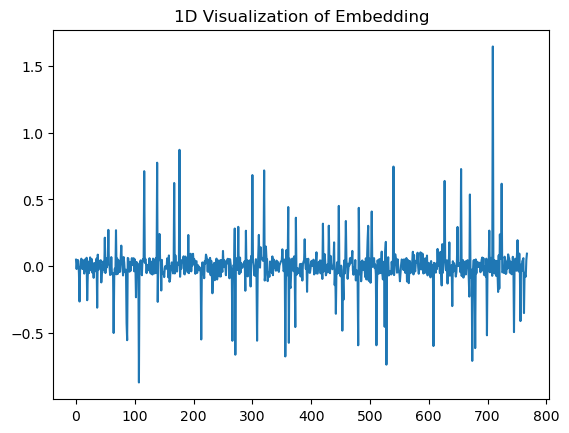

1
torch.Size([768])


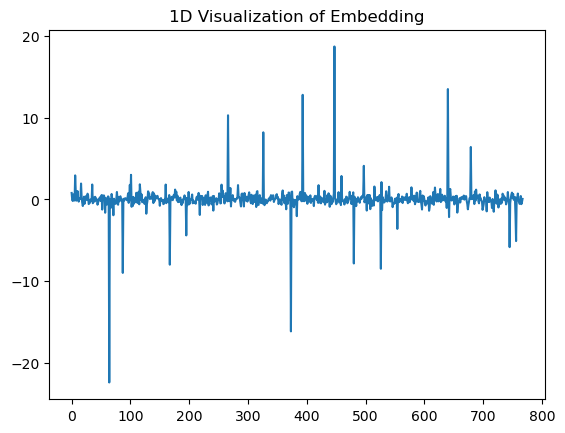

2
torch.Size([768])


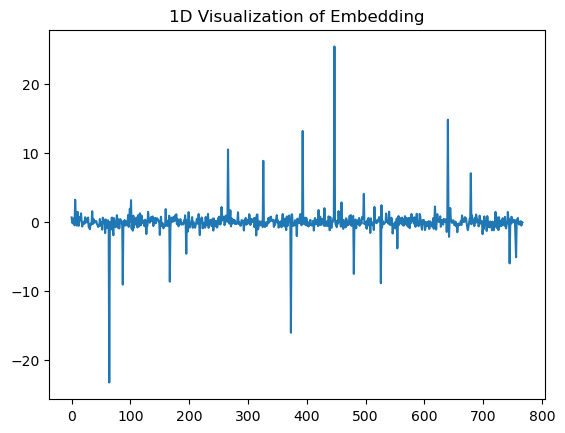

3
torch.Size([768])


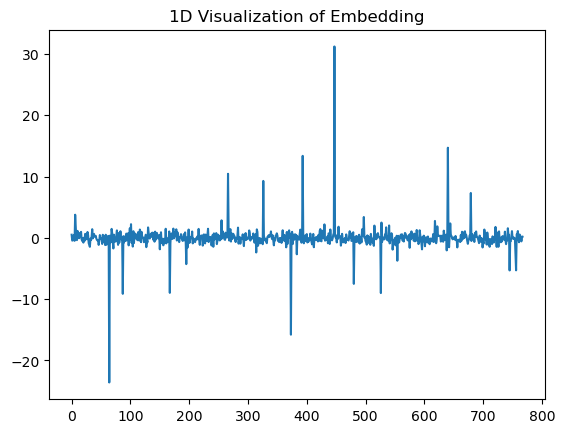

4
torch.Size([768])


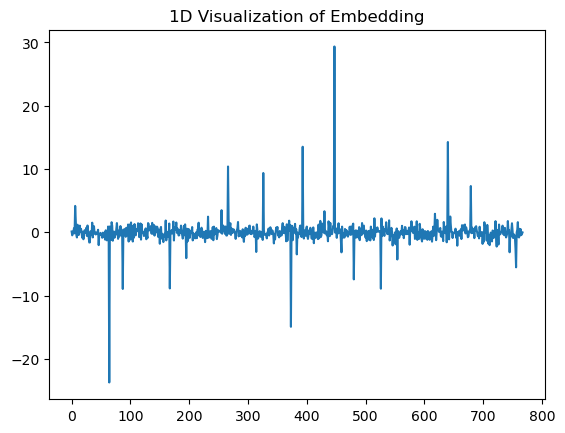

5
torch.Size([768])


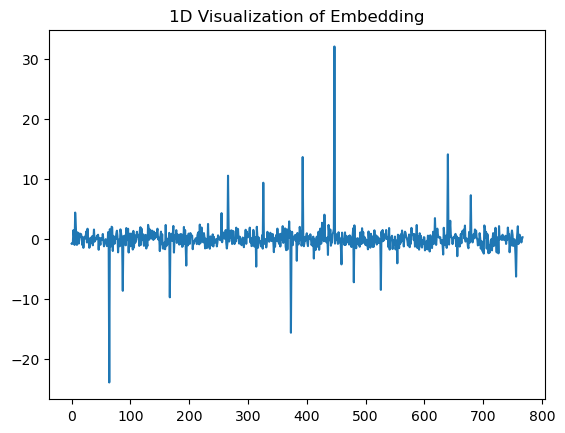

6
torch.Size([768])


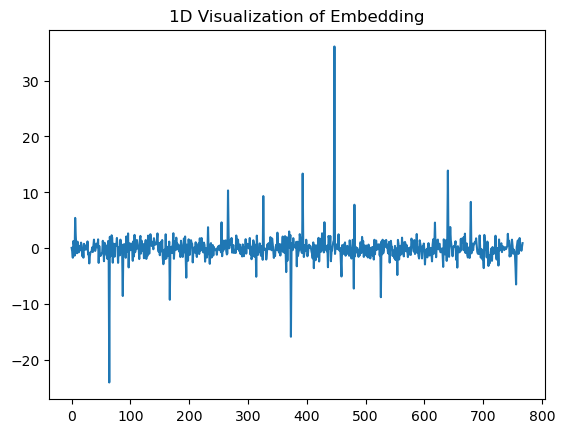

7
torch.Size([768])


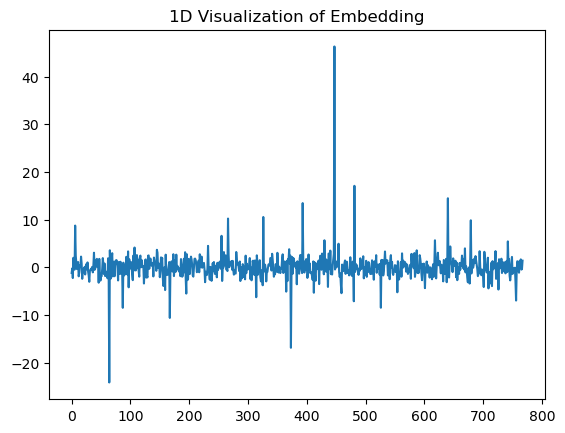

8
torch.Size([768])


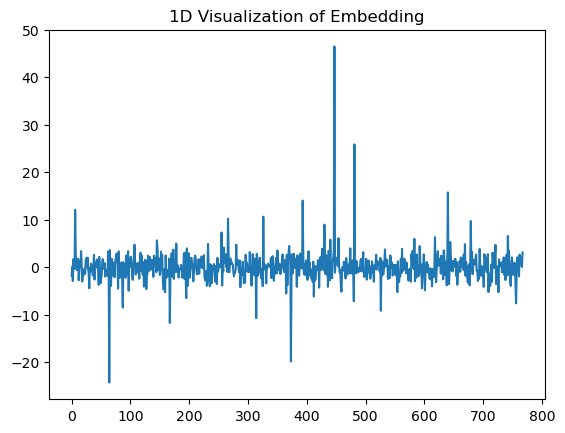

9
torch.Size([768])


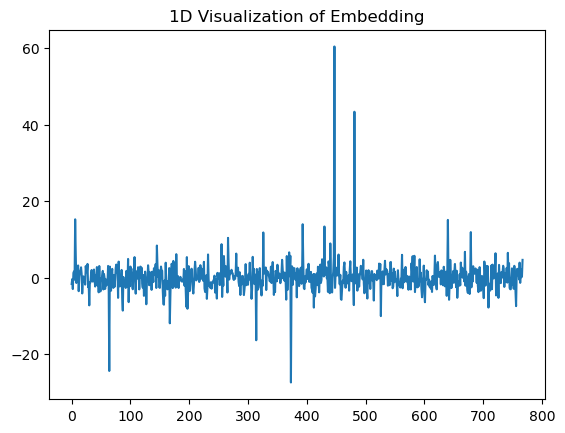

10
torch.Size([768])


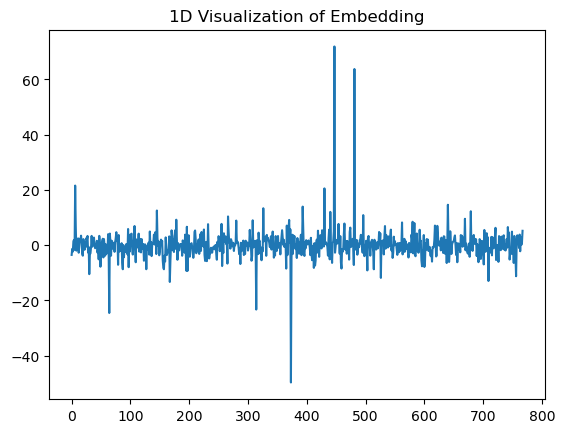

11
torch.Size([768])


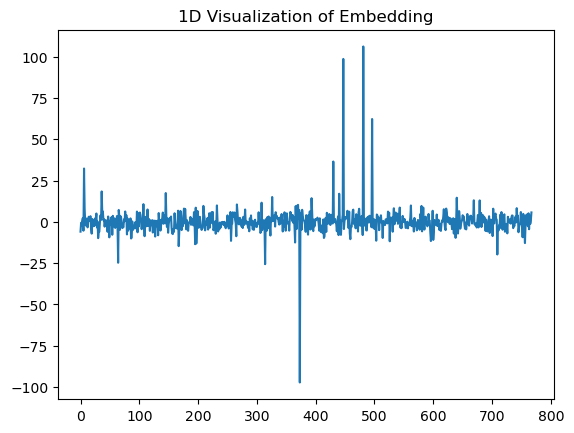

12
torch.Size([768])


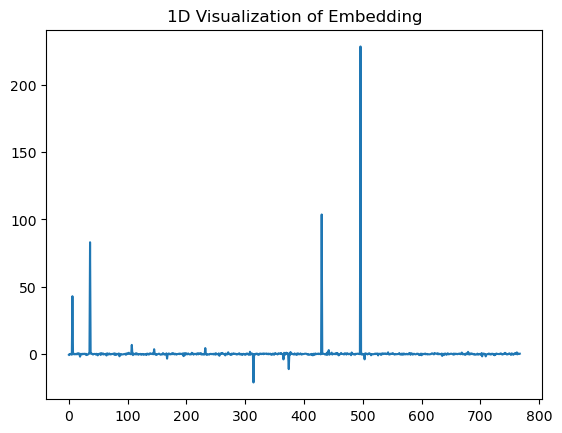

In [28]:

#ENTROPY 
#projection of that cevotrs

for i in range(len(hidden_states)):
    print(i)
    last_hidden_layer = hidden_states[i]
    embeddings = last_hidden_layer[1, -1, :]  # Shape: (batch_size, embedding_dim)  I'M TAKING FIRST TOKEN 
    print(embeddings.shape)
    plt.plot(embeddings.numpy().flatten())
    plt.title("1D Visualization of Embedding")
    plt.show()

**PLOT ALL BATCH TOGHEDER**

Layer 0
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


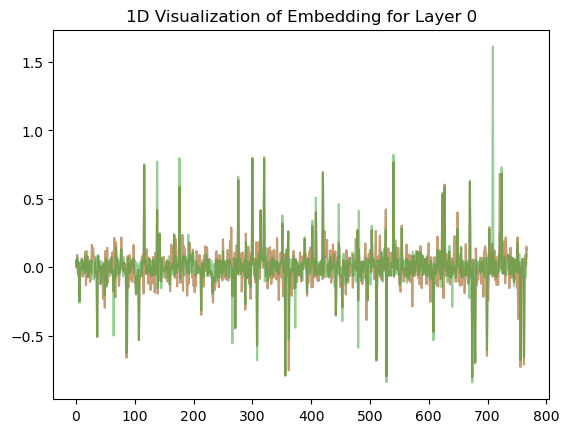

Layer 1
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


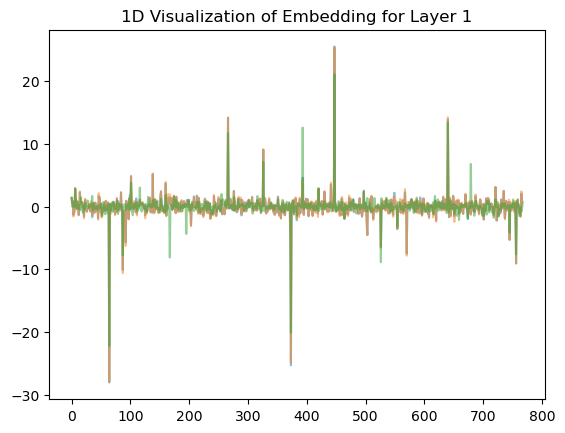

Layer 2
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


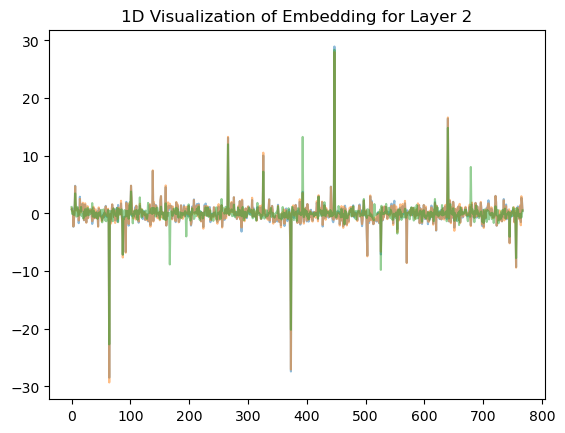

Layer 3
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


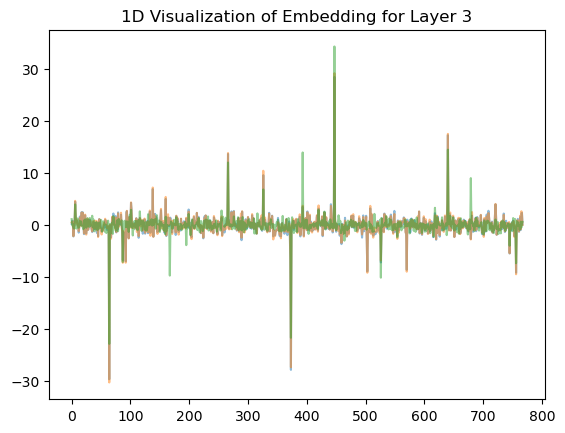

Layer 4
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


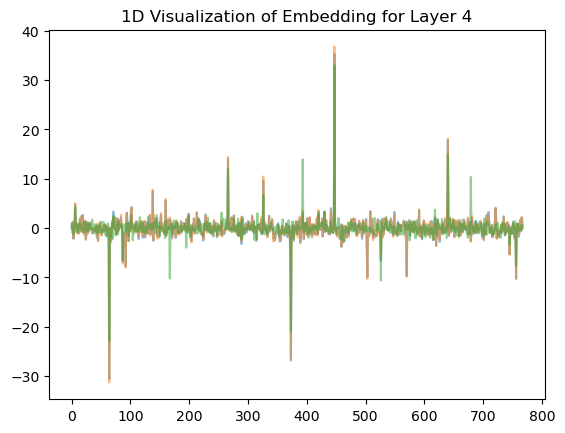

Layer 5
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


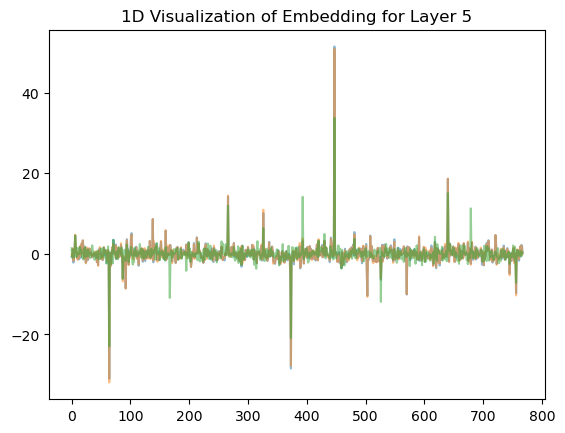

Layer 6
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


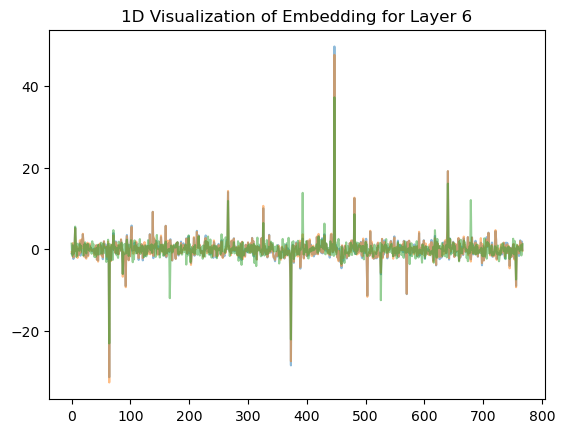

Layer 7
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


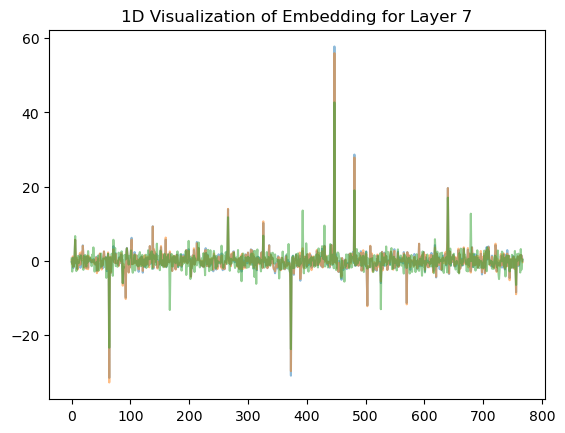

Layer 8
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


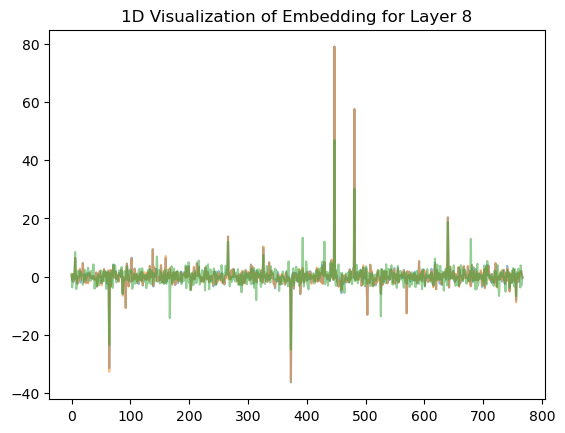

Layer 9
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


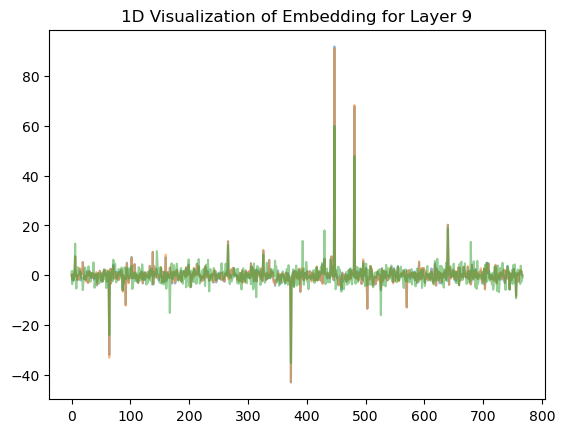

Layer 10
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


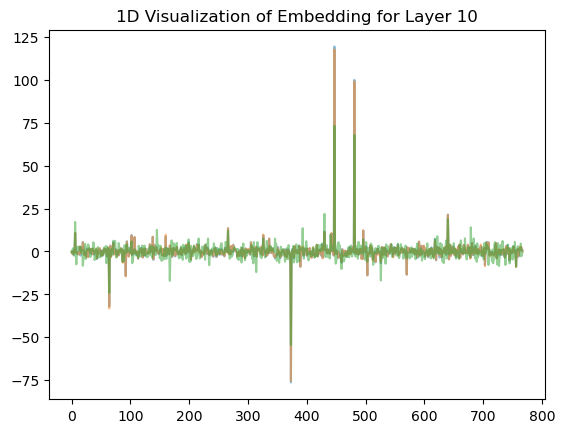

Layer 11
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


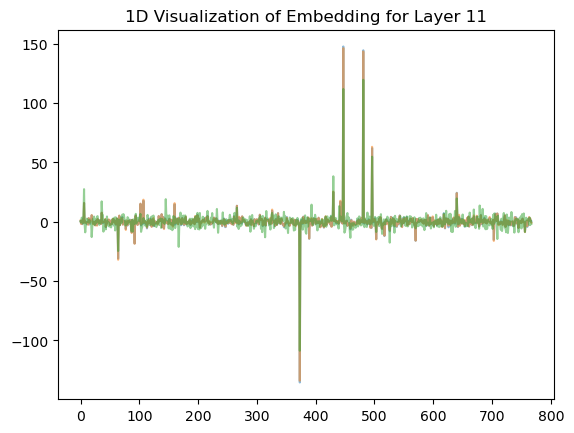

Layer 12
Batch 0 Embedding Shape: torch.Size([768])
Batch 1 Embedding Shape: torch.Size([768])
Batch 2 Embedding Shape: torch.Size([768])


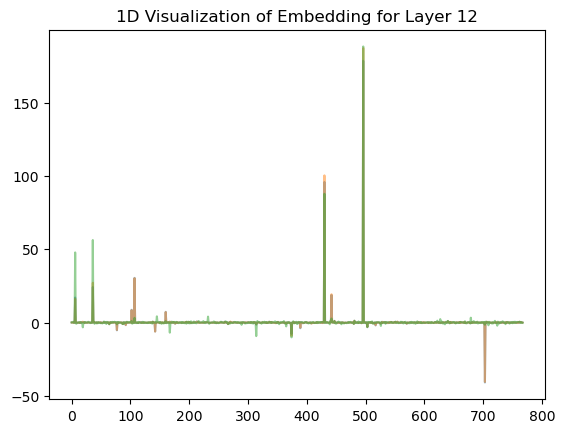

In [25]:
#FA SCHIFO, però ero curioso di vedere se ci fossero "correlazioni" in comune.
# secondo voi si può dire che nell'ultimo layer i picchi rappresentano le caratteristiche in comune (in questo caso-> frutta)?


for i in range(len(hidden_states)):
    print(f"Layer {i}")
    last_hidden_layer = hidden_states[i]  # Shape: (batch_size, sequence_length, hidden_size)
    
  
    for batch_idx in range(last_hidden_layer.shape[0]):  # batch dimension
        embeddings = last_hidden_layer[batch_idx, -1, :]  # Take the last token's embedding for each batch
        print(f"Batch {batch_idx} Embedding Shape: {embeddings.shape}")
        plt.plot(embeddings.numpy().flatten(), label=f"{text[batch_idx]}", alpha=0.5)
    

    plt.title(f"1D Visualization of Embedding for Layer {i}")
  #  plt.legend() 
    plt.show()

In [8]:

"""The value of each dimension indicates how strongly the input data correlates with that feature.
For example:

One dimension might encode sentiment (positive/negative).
Another dimension might encode part-of-speech information (noun, verb).
Yet another might encode syntactic relationships (subject, object).
However, these features are not human-interpretable, as they are learned automatically during training."""

"""Positive Values: Strong activation or alignment with the feature.
Negative Values: Negative correlation or opposite alignment with the feature.
Values Near Zero: Weak or no correlation with the feature."""

'Positive Values: Strong activation or alignment with the feature.\nNegative Values: Negative correlation or opposite alignment with the feature.\nValues Near Zero: Weak or no correlation with the feature.'

### Short Prompts (1–5 words)
Good for analyzing minimal context and word-level embeddings.

- "Sunset"

- "The quick fox"

- "Hello world"

- "Once upon a"

- "Artificial intelligence"

### Medium Prompts (6–15 words)
Useful for observing basic syntactic and semantic patterns.

- "The cat sat on the warm windowsill and purred quietly."

- "He opened the door to find a mysterious package waiting."

- "Deep learning has revolutionized computer vision and natural language processing."

- "A sudden noise startled her while she was reading a book."

- "The recipe called for eggs, flour, sugar, and a pinch of salt."

### Long Prompts (16–50 words)
Better for studying how GPT-2 processes extended context or narrative flow.

- "The scientist carefully adjusted the settings on the control panel, knowing that one wrong move could trigger a catastrophic failure that would destroy years of research and potentially endanger lives."

- "In a future where machines have gained consciousness, a lone programmer works tirelessly to insert a backdoor into the system, hoping to reclaim control of a world slipping away."

- "During the final debate, the candidate made a passionate appeal to unity, addressing both critics and supporters, promising transparency, economic reform, and a renewed focus on international cooperation."

### Very Long Prompt (50+ words)
Use this to test GPT-2’s capacity limits, token truncation, and how it handles deeper coherence.

- "As the storm raged outside, Maria sat by the fireplace, recalling the last letter her brother had sent before disappearing in the mountains. It spoke of a hidden temple, an ancient curse, and a secret he had vowed to protect at all costs. Her hands trembled as she read it again."

(Prompt with dialogue and descriptive elements)
- "“I never asked for this,” he whispered, staring at the broken mask in his hands. Around him, the ruins of the facility burned, casting eerie shadows on the bloodstained walls. Footsteps echoed in the corridor—someone was still alive. And they were looking for him."

In [10]:
prompts = {
    "short": [
        "Sunset",
        "The quick fox",
        "Hello world",
        "Once upon a",
        "Artificial intelligence"
    ],
    "medium": [
        "The cat sat on the warm windowsill and purred quietly.",
        "He opened the door to find a mysterious package waiting.",
        "Deep learning has revolutionized computer vision and natural language processing.",
        "A sudden noise startled her while she was reading a book.",
        "The recipe called for eggs, flour, sugar, and a pinch of salt."
    ],
    "long": [
        "The scientist carefully adjusted the settings on the control panel, knowing that one wrong move could trigger a catastrophic failure that would destroy years of research and potentially endanger lives.",
        "In a future where machines have gained consciousness, a lone programmer works tirelessly to insert a backdoor into the system, hoping to reclaim control of a world slipping away.",
        "During the final debate, the candidate made a passionate appeal to unity, addressing both critics and supporters, promising transparency, economic reform, and a renewed focus on international cooperation."
    ],
    "very_long": [
        "As the storm raged outside, Maria sat by the fireplace, recalling the last letter her brother had sent before disappearing in the mountains. It spoke of a hidden temple, an ancient curse, and a secret he had vowed to protect at all costs. Her hands trembled as she read it again.",
        "“I never asked for this,” he whispered, staring at the broken mask in his hands. Around him, the ruins of the facility burned, casting eerie shadows on the bloodstained walls. Footsteps echoed in the corridor—someone was still alive. And they were looking for him."
    ],
    "closed": [
        "The capital of France is", 
        "Water freezes at 0 degrees",
        "The currency used in Japan is the",
        "The chemical symbol for gold is",
        "The author of Romeo and Juliet is",
        "The largest planet in our solar system is",
        "The primary language spoken in Brazil is",
        "The square root of 64 is",
        "The opposite of hot is",
        "The Great Wall is located in"
    ]
}

# TO USE:
# for category, prompt_list in prompts.items():
#    for prompt in prompt_list:
#        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
#        outputs = model(**inputs)
#        # your embedding analysis here...


In [175]:


def token(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

    print("🧾 Tokens:")
    for idx, tok in enumerate(tokens):
        print(f"{idx:2}: {tok}")

    gen_output = model.generate(
        input_ids,
        max_new_tokens=10,
        do_sample=False,
        return_dict_in_generate=True,
        output_scores=True)

    gen_ids = gen_output.sequences[0]
    generated_token_ids = gen_ids[input_ids.shape[1]:]
    generated_tokens = tokenizer.convert_ids_to_tokens(generated_token_ids)
    generated_text = tokenizer.decode(generated_token_ids)

    print("\n📝 Generated Text:")
    print(generated_text)

    return inputs, generated_token_ids, tokens, generated_tokens





prompt = "The author of Romeo and Juliet is William"
inputs, outputs, tokens, generated_tokens = token(prompt)



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


🧾 Tokens:
 0: The
 1: Ġauthor
 2: Ġof
 3: ĠRomeo
 4: Ġand
 5: ĠJuliet
 6: Ġis
 7: ĠWilliam

📝 Generated Text:
 Shakespeare, and he is the author of the novel


In [176]:

def attention(inputs):
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    logits = outputs.logits
    attentions = outputs.attentions
    hidden_state = outputs.hidden_states
    
    return (logits, attentions, hidden_state )


logits_prompt, attentions_prompt, hidden_state_prompt = attention(inputs)

generated_inputs = {"input_ids": generated_token_ids.unsqueeze(0)}  # Add batch dimension
logits_generated, attentions_generated, hidden_state_generated = attention(generated_inputs)


In [177]:
#SEE THE MOST PROBABLE NEXT TOKEN FOR EACH TOKEN

def top_k(logits, attentions, tokens):
    top_k = 5
    vocab_size = logits.shape[-1]

    print("\nTop-5 Predictions at Each Step:")
    for step in range(logits.shape[1]):
        probs = torch.softmax(logits[0, step], dim=-1)
        top_probs, top_indices = torch.topk(probs, k=top_k)
        top_tokens = tokenizer.convert_ids_to_tokens(top_indices.tolist())
        token_str = tokens[step] if step < len(tokens) else "<PAD/UNK>"
        print(f"\nStep {step:2} | Token: {token_str}")
        for rank in range(top_k):
            print(f"  {rank+1:2}: {top_tokens[rank]:>12} ({top_probs[rank].item():.4f})")


top_k(logits_prompt, attentions_prompt,  tokens )
top_k(logits_generated, attentions_generated, generated_tokens )


Top-5 Predictions at Each Step:

Step  0 | Token: The
   1:            Ċ (0.0136)
   2:         Ġthe (0.0100)
   3:           Ġ" (0.0082)
   4:            , (0.0063)
   5:           Ġa (0.0052)

Step  1 | Token: Ġauthor
   1:          Ġof (0.1863)
   2:          Ġis (0.0930)
   3:            , (0.0746)
   4:           's (0.0569)
   5:        Ġalso (0.0457)

Step  2 | Token: Ġof
   1:         Ġthe (0.2932)
   2:           Ġ" (0.1172)
   3:        Ġthis (0.0938)
   4:           Ġa (0.0561)
   5:         ĠThe (0.0479)

Step  3 | Token: ĠRomeo
   1:         Ġand (0.6700)
   2:           Ġ& (0.1289)
   3:            , (0.0344)
   4:         ĠAnd (0.0205)
   5:           's (0.0144)

Step  4 | Token: Ġand
   1:      ĠJuliet (0.9848)
   2:         Ġthe (0.0108)
   3:         ĠThe (0.0004)
   4:      ĠCaesar (0.0002)
   5:       ĠRobin (0.0002)

Step  5 | Token: ĠJuliet
   1:            , (0.3405)
   2:          Ġis (0.0631)
   3:            : (0.0620)
   4:           Ġ( (0.0570)
   5:      

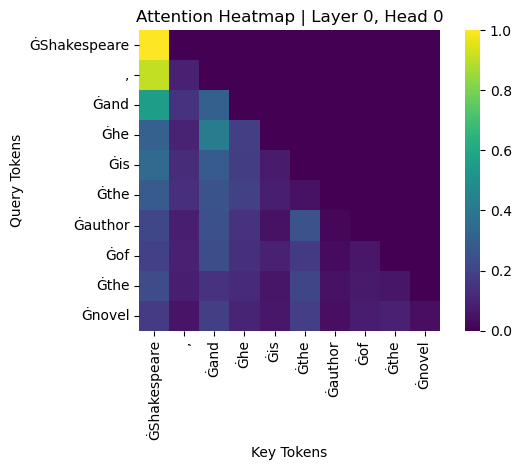

In [178]:
def plot_attention_matrix(att_matrix, tokens, layer=0, head=0):
    # Extract the attention matrix for the specified layer and head
    attn = att_matrix[layer][0, head].detach().numpy()

    # Filter out <PAD> and <UNK> tokens and their corresponding rows/columns
    valid_indices = [i for i, token in enumerate(tokens) if token not in ("<PAD>", "<UNK>")]
    filtered_attn = attn[np.ix_(valid_indices, valid_indices)]
    filtered_tokens = [tokens[i] for i in valid_indices]

    # Plot the attention heatmap
    sns.heatmap(filtered_attn, xticklabels=filtered_tokens, yticklabels=filtered_tokens, cmap="viridis", square=True, cbar=True)
    plt.title(f"Attention Heatmap | Layer {layer}, Head {head}")
    plt.xlabel("Key Tokens")
    plt.ylabel("Query Tokens")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Example: Layer 0, Head 0
#plot_attention_matrix(attentions, tokens, layer=0, head=0)
plot_attention_matrix( attentions_generated, generated_tokens, layer=0, head=0)

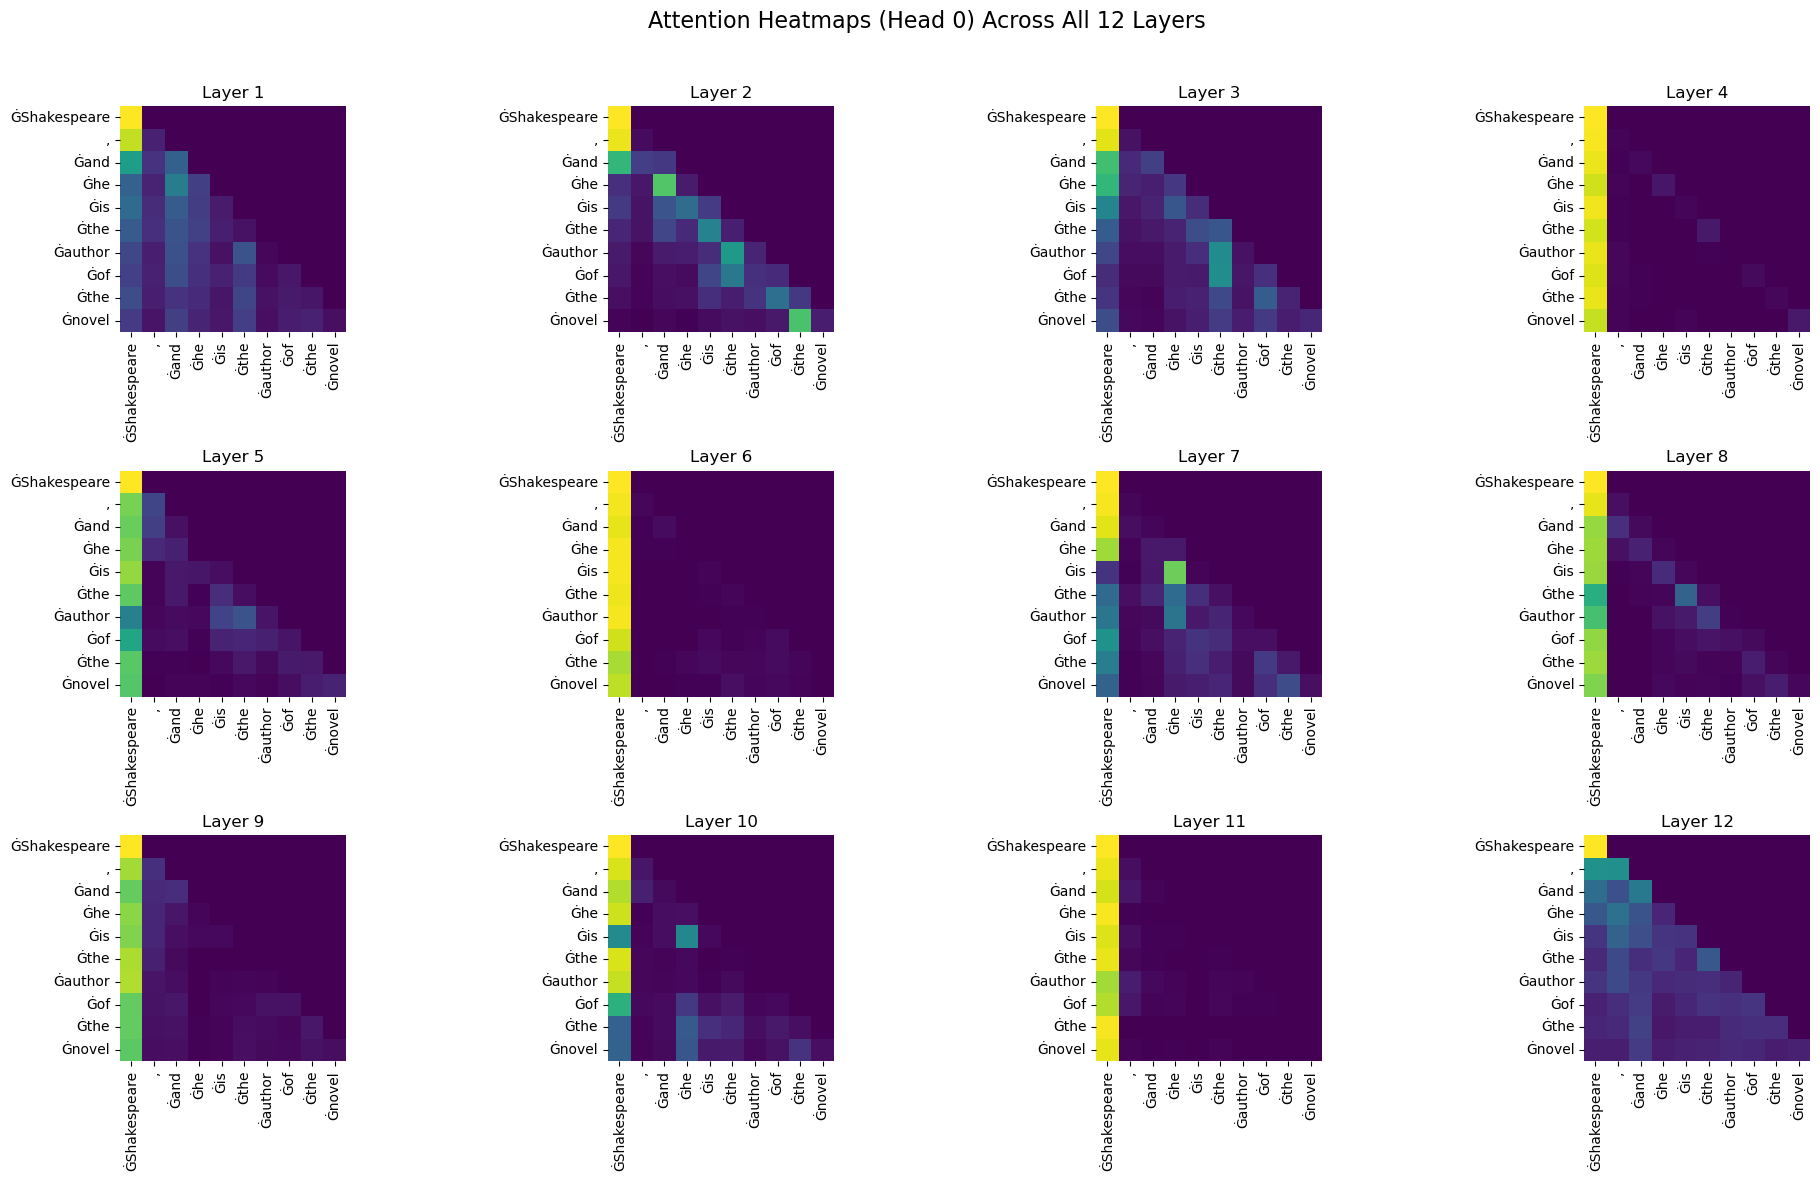

In [179]:
#SEE MOST PROBABLE NEXT TOKEN AND ATTENTION AT EACH LAYER
model.eval()
"""
# Input text
prompt = " boiling temperature of water?"
#"The author of Romeo and Juliet is William"
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])


# Forward pass with hidden states
with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions  # List of tensors: [layer][batch, head, seq_len, seq_len]
"""
def PCA(hidden_states):
    n_layers = len(hidden_states)

    # Language modeling head
    lm_head = model.lm_head  # Linear layer from hidden dim -> vocab size
    top_k = 5  # Change as needed
    token_position = -1  # Last token in prompt

    print(f"Prompt: {prompt}\n")

    for i in range(1, n_layers):  # skip embeddings (index 0)
        hidden = hidden_states[i]  # shape: [1, seq_len, hidden_dim]
        last_token_vec = hidden[0, token_position, :]  # shape: [hidden_dim]
        logits = lm_head(last_token_vec)  # shape: [vocab_size]
        probs = torch.softmax(logits, dim=-1)
        top_probs, top_ids = torch.topk(probs, top_k)
        top_tokens = tokenizer.convert_ids_to_tokens(top_ids)

        print(f"Layer {i:2d}:")
        for j in range(top_k):
            print(f"  {j+1:2d}: {top_tokens[j]:>10} ({top_probs[j].item():.4f})")


def plot_attention_layers(attentions, tokens, head_idx=0):
    num_layers = len(attentions)
    seq_len = len(tokens)

    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    fig.suptitle(f"Attention Heatmaps (Head {head_idx}) Across All 12 Layers", fontsize=16)

    for i in range(num_layers):
        ax = axes[i // 4, i % 4]
        attn = attentions[i][0, head_idx, :, :].detach().numpy()
        sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="viridis", ax=ax, square=True, cbar=False)
        ax.set_title(f"Layer {i+1}")
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

#plot_attention_layers(attentions, tokens, head_idx=0)
plot_attention_layers(attentions_generated, generated_tokens, head_idx=0)


To analyze the dynamics of hidden states across layers, you're essentially exploring how the internal token representations evolve at each layer of the transformer. Here are several ways you can analyze and visualize these dynamics effectively:

1. Cosine Similarity Between Layers

Measure how the hidden representation of a specific token (e.g., the last token "William") changes across layers.
Cosine similarity is a measure of similarity between two vectors based on the angle between them—not their length. It's commonly used in natural language processing (NLP) to compare how "similar" two token embeddings or hidden states are.

Formula:
For two vectors A and B, the cosine similarity is:

cosine_similarity(𝐴,𝐵)=𝐴⋅𝐵/(∥𝐴∥∥𝐵∥)

1.0 → Vectors point in the same direction → Very similar

0.0 → Vectors are orthogonal (90° apart) → No similarity

–1.0 → Vectors point in opposite directions → Completely dissimilar
​

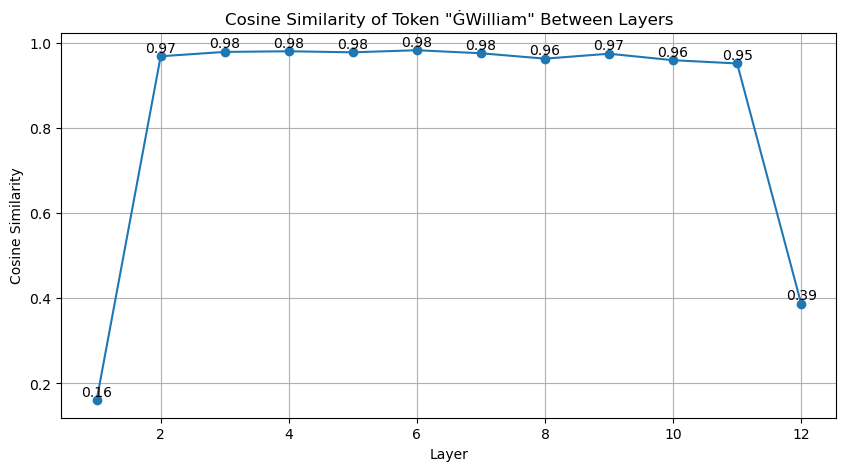

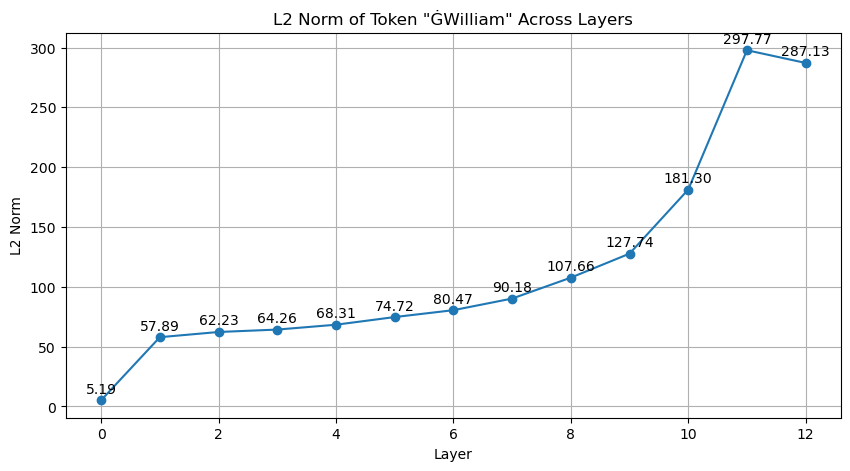

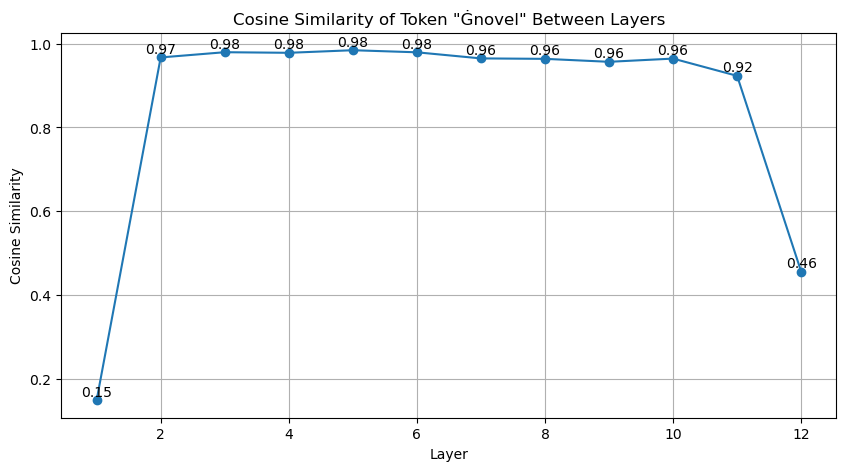

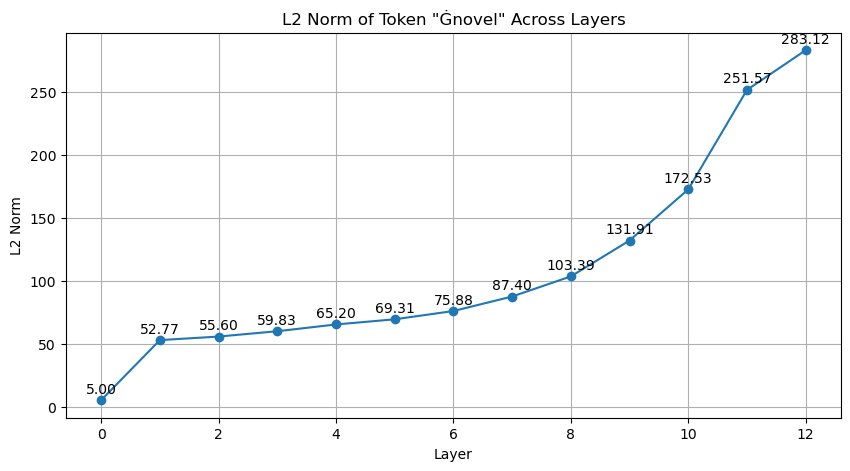

In [180]:
from sklearn.metrics.pairwise import cosine_similarity

def plot_cosine_similarity(hidden_states, tokens, token_position=-1):
    """
    Plots cosine similarity of a token's hidden state across model layers.

    Parameters:
        hidden_states (List[Tensor]): List of hidden states for each layer, shape [1, seq_len, hidden_dim]
        tokens (List[str]): List of tokens from the tokenizer
        token_position (int): Position of the token to track (default: -1 for the last token)
    """

    n_layers = len(hidden_states)

    # Extract the hidden state vectors across layers for the selected token
    vectors = [hidden_states[i][0, token_position].detach().numpy() for i in range(n_layers)]

    # Compute cosine similarities between consecutive layers
    cos_sims = [cosine_similarity([vectors[i]], [vectors[i+1]])[0][0] for i in range(n_layers - 1)]

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_layers), cos_sims, marker='o')
    plt.title(f'Cosine Similarity of Token "{tokens[token_position]}" Between Layers')
    plt.xlabel('Layer')
    plt.ylabel('Cosine Similarity')
    plt.grid(True)

    # Annotate points with similarity values
    for i, sim in enumerate(cos_sims, 1):
        plt.text(i, sim + 0.01, f"{sim:.2f}", ha='center')

    plt.show()

    norms = [np.linalg.norm(vectors[i]) for i in range(n_layers)]
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(n_layers), norms, marker='o')
    plt.title(f'L2 Norm of Token "{tokens[token_position]}" Across Layers')
    plt.xlabel('Layer')
    plt.ylabel('L2 Norm')
    plt.grid(True)

    for i, sim in enumerate(norms):
        plt.text(i, sim + (max(norms) * 0.02), f"{sim:.2f}", ha='center', fontsize=10)  # Slightly above the point
     
    plt.show()

    return(vectors)

    
    
vectors_prompt=plot_cosine_similarity(hidden_states, tokens, token_position=-1)
vectors_generated=plot_cosine_similarity(hidden_state_generated, generated_tokens, token_position=-1)

2. Hidden State Norms

See how the magnitude (L2 norm) of token vectors changes with depth. High/low norms can indicate activation saturation or sparsity.

3. Dimensionality Projection (e.g., PCA or t-SNE)

You can visualize the full trajectory of a token in reduced space.


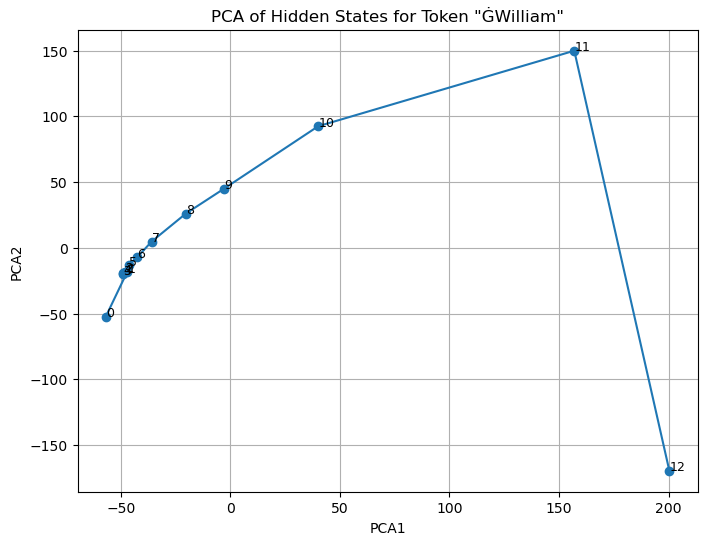

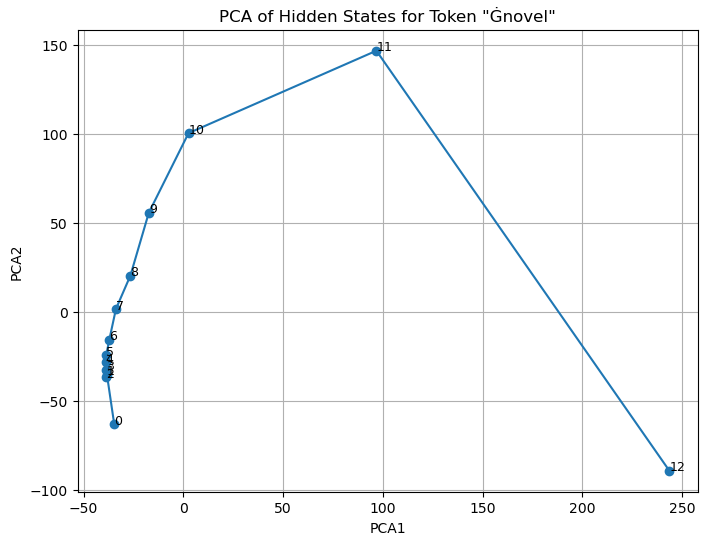

In [181]:
from sklearn.decomposition import PCA
def pca(vectors, tokens, token_position):
    
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)

    plt.figure(figsize=(8, 6))
    plt.plot(reduced[:, 0], reduced[:, 1], marker='o')
    for i, (x, y) in enumerate(reduced):
        plt.text(x + 0.01, y + 0.01, f'{i}', fontsize=9)
    
    plt.title(f'PCA of Hidden States for Token "{tokens[token_position]}"')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.grid(True)
    plt.show()

pca(vectors_prompt, tokens, token_position=-1)
pca(vectors_generated,generated_tokens, token_position=-1)

4. Compare Multiple Tokens

If you're curious about token interaction (like "William" and "Shakespeare"), you can track their relative positions over layers.

Tracking tokens at positions: [('Ġauthor', 1), ('Ġof', 2), ('ĠRomeo', 3), ('Ġand', 4), ('Ġis', 6), ('ĠWilliam', 7)]


C:\Users\lucaf\AppData\Local\Temp\ipykernel_4912\4273857749.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('tab10')


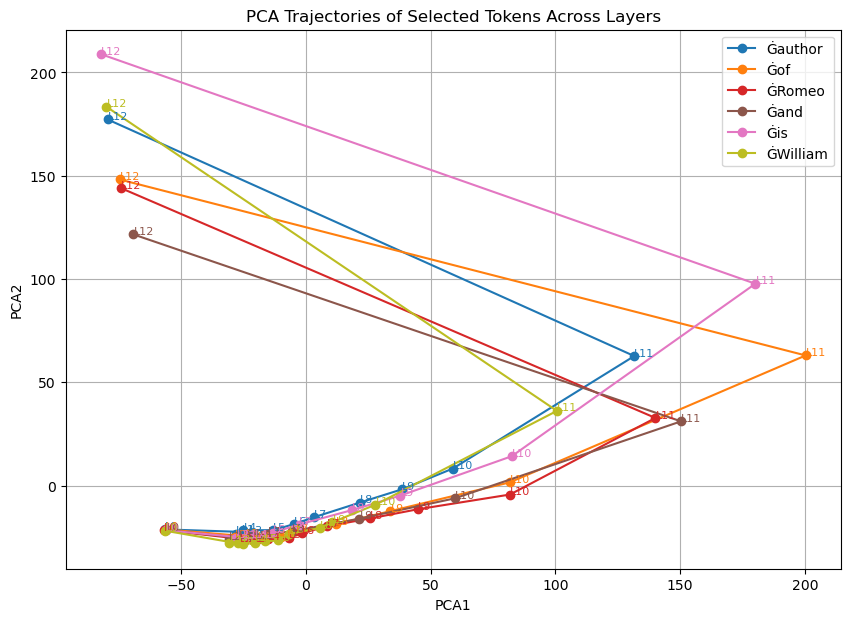

Tracking tokens at positions: [('Ġand', 2), ('Ġis', 4), ('Ġauthor', 6), ('Ġof', 7)]


C:\Users\lucaf\AppData\Local\Temp\ipykernel_4912\4273857749.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = get_cmap('tab10')


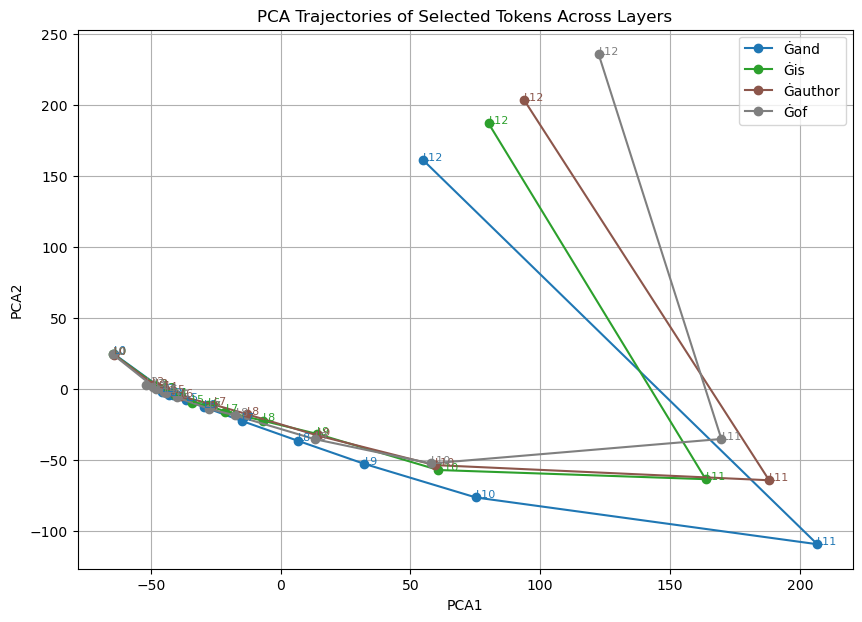

In [193]:
from matplotlib.cm import get_cmap

def multiple_tokens(target_tokens, tokens,hidden_states):
    token_indices = [i for i, tok in enumerate(tokens) if any(t in tok for t in target_tokens)]
    tracked_tokens = [tokens[i] for i in token_indices]

    print("Tracking tokens at positions:", list(zip(tracked_tokens, token_indices)))

    token_trajectories = {tok: [] for tok in tracked_tokens}

    n_layers = len(hidden_states)
   
    for i in range(n_layers):
        for tok, idx in zip(tracked_tokens, token_indices):
            vec = hidden_states[i][0, idx].numpy()
            token_trajectories[tok].append(vec)

    # Combine all vectors to fit PCA
    all_vecs = np.concatenate([token_trajectories[tok] for tok in tracked_tokens], axis=0)
    pca = PCA(n_components=2)
    all_reduced = pca.fit_transform(all_vecs)

    # Split back into token trajectories
    offset = 0
    token_reduced = {}
    for tok in tracked_tokens:
        token_reduced[tok] = all_reduced[offset:offset + n_layers]
        offset += n_layers

    # Plot
    plt.figure(figsize=(10, 7))
    
    colormap = get_cmap('tab10')
    colors = [colormap(i / len(tracked_tokens)) for i in range(len(tracked_tokens))]

    for tok, col in zip(tracked_tokens, colors):
        coords = token_reduced[tok]
        x, y = zip(*coords)
        plt.plot(x, y, marker='o', label=tok, color=col)
        for i, (px, py) in enumerate(coords):
            plt.text(px + 0.01, py + 0.01, f'L{i}', fontsize=8, color=col)

    plt.title("PCA Trajectories of Selected Tokens Across Layers")
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.legend()
    plt.grid(True)
    plt.show()


# Choose tokens you want to track
#"The author of Romeo and Juliet is William"
target_tokens =["Romeo", "author", "of","and", "is", "William"]

multiple_tokens(target_tokens, tokens, hidden_state_prompt )
multiple_tokens(target_tokens, generated_tokens, hidden_state_generated )

5. Mean/Variance of All Tokens

See whether the model tends to compress or expand representations globally:

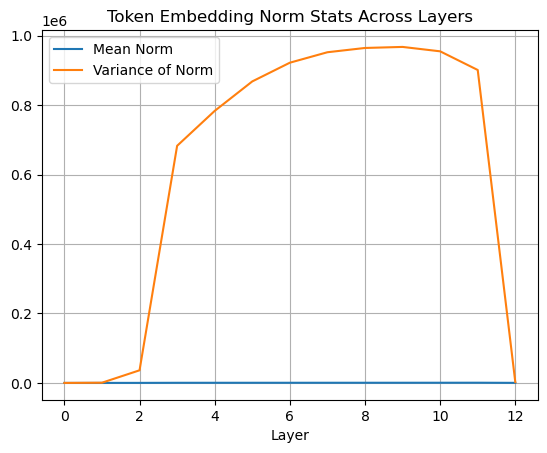

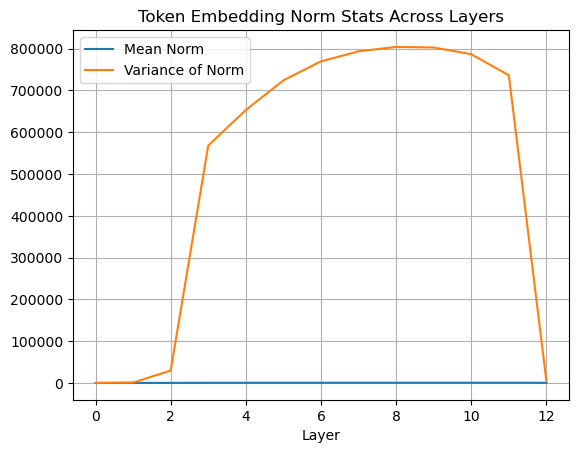

In [195]:
def norm(hidden_states):
         
    n_layers = len(hidden_states)         
    all_norms = [
        torch.norm(hidden_states[i][0], dim=-1).numpy()  # shape: [seq_len]
        for i in range(n_layers)]

    mean_norms = [np.mean(layer_norms) for layer_norms in all_norms]
    var_norms = [np.var(layer_norms) for layer_norms in all_norms]

    plt.plot(mean_norms, label='Mean Norm')
    plt.plot(var_norms, label='Variance of Norm')
    plt.title('Token Embedding Norm Stats Across Layers')
    plt.xlabel('Layer')
    plt.legend()
    plt.grid(True)
    plt.show()

norm(hidden_state_prompt)
norm(hidden_state_generated)